In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")    
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [18]:
def plot_verification(df):
    PAGESIZE = 4096
    compact_ios = (df['compact_read'] + df['compact_write']) / PAGESIZE
    df['write_ios'] = ((df['bytes_written'] + df['flush_written']) / PAGESIZE) + compact_ios
    df['total_ios'] = df['blocks_read'] + df['write_ios']
    df['io_per_query'] = df['total_ios'] / 100000
    df['model_io_per_query'] = df['model_io'] / 100000
    
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    ax.plot(df['N'], df['io_per_query'],       marker='o', color='blue', label='System')
    ax2.plot(df['N'], df['model_io_per_query'],marker='*', color='black', label='Model')
    ax.set_xscale('log')
    ax.set_ylabel('System I/Os per Query', color='blue')
    ax.set_xlabel('Number of Elements in DB (N)')
    ax2.set_ylabel('Model I/Os per Query', color='black')
    ax.tick_params(axis='y', colors='blue')
    ax.set_title('Verification of Database Size')
    plt.show()

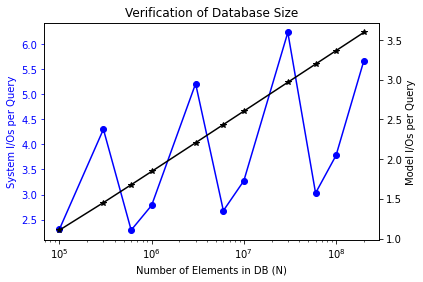

In [19]:
df = dp.read_csv('exp_04_leveling.csv')
plot_verification(df)

In [11]:
df

,N,phi,s,B,E,M,is_leveling_policy,T,h,l0_hit,l1_hit,l2_plus_hit,z0_ms,z1_ms,q_ms,w_ms,filter_neg,filter_pos,filter_pos_true,bytes_written,compact_read,compact_write,flush_written,blocks_read,runs_per_level,model_io,write_ios,total_ios,io_per_query,model_io_per_query
0,100000.0,1,0.0,4,8192,6.810886e+07,True,8,10,2793,22207,0,29,3521,10376,520,72130,25076,25000,26000000,242555858,241092608,26070878,100002,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",110634.235599,130790.855469,230792.855469,2.307929,1.106342
1,300000.0,1,0.0,4,8192,7.010886e+07,True,8,10,2749,22251,0,29,3024,8367,1379,72169,25079,25000,26000000,651712726,648045056,26070366,99921,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",145243.801126,330036.168945,429957.168945,4.299572,1.452438
2,600000.0,1,0.0,4,8192,7.310886e+07,True,8,10,428,2893,21679,34,2634,11996,423,121165,25085,25000,26000000,189336464,187708928,26083678,124326,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",167726.200470,104767.839355,229093.839355,2.290938,1.677262
3,1000000.0,1,0.0,4,8192,7.710886e+07,True,8,10,358,2976,21666,33,2424,11431,616,121220,25084,25000,26000000,291087531,288887296,26084702,124102,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",184436.384504,154311.408447,278413.408447,2.784134,1.844364
4,3000000.0,1,0.0,4,8192,9.710886e+07,True,8,10,464,3533,21003,34,2245,9210,1660,120470,25068,25000,26000000,793051761,788119040,26084714,122174,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",220578.860821,398744.022217,520918.022217,5.209180,2.205789
5,6000000.0,1,0.0,4,8192,1.271089e+08,True,8,10,75,575,24350,43,2273,12265,506,169251,25072,25000,26000000,227520893,225443840,26098026,144509,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",243451.541468,123306.337646,267815.337646,2.678153,2.434515
6,10000000.0,1,0.0,4,8192,1.671089e+08,True,8,10,87,730,24183,38,2199,11364,749,168103,25071,25000,26000000,355199224,351893504,26098026,141979,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",260322.299905,185349.305176,327328.305176,3.273283,2.603223
7,30000000.0,1,0.0,4,8192,3.671089e+08,True,8,10,206,1484,23310,43,2244,9089,1999,162445,25082,25000,26000000,977226403,970579968,26098026,134736,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",296626.310938,488257.909424,622993.909424,6.229939,2.966263
8,60000000.0,1,0.0,4,8192,6.671089e+08,True,8,10,68,343,24589,47,2303,11752,594,206318,25067,25000,26000000,275897927,273176576,26111338,156143,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",319538.598048,146773.886963,302916.886963,3.029169,3.195386
9,100000000.0,1,0.0,4,8192,1.067109e+09,True,8,10,64,515,24421,49,2286,11048,912,200380,25060,25000,26000000,433299740,430665216,26111338,154215,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",336425.587498,223651.438965,377866.438965,3.778664,3.364256
